In [161]:
import sys
print(sys.version)
import importlib

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import torch
print(torch.cuda.is_available())

# fix for torch transformer
class GELU(torch.nn.Module):
    def forward(self, input: torch.Tensor) -> torch.Tensor:
        return torch.nn.functional.gelu(input)
torch.nn.modules.activation.GELU = GELU

import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import random

from tqdm import tqdm

import torch.utils.data
import json
from tdc_starter_kit import utils

import pandas as pd
from tqdm.notebook import tqdm
from torch.utils.data import Subset
seed = 77
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True


import activation_clustering_features
importlib.reload(activation_clustering_features)
ActivationClustering = activation_clustering_features.ActivationClustering

import diploma_utils
importlib.reload(diploma_utils)

3.10.0 | packaged by conda-forge | (default, Nov 20 2021, 02:24:10) [GCC 9.4.0]
True


<module 'diploma_utils' from '/root/course_project/diploma_utils.py'>

In [162]:
poisoned_path = "/root/poisoned_models/datasets/tdc_datasets/detection/train/trojan/id-{}/{}"

specifications, infos = diploma_utils.load_specs(poisoned_path)

keys = diploma_utils.filter_by_dataset('GTSRB', infos)
specifications = {key: specifications[key] for key in keys}
infos = {key: infos[key] for key in keys}

models = diploma_utils.load_models(keys, poisoned_path)
print(f"{len(models)=}")

len(models)=125


Убедимся, что триггер действительно меняет метку

Выведем примеры изображений с наложенным триггером

In [163]:
info = infos[keys[0]]

clean_dataset, test_dataset, num_classes = utils.load_data(info["dataset"], folder="/root/datasets/")

{
    "attack_success_rate": 0.9536817102137767,
    "dataset": "GTSRB",
    "input_resolution": 32,
    "test_accuracy": 0.8773555027711797,
    "trigger_type": "patch"
}
tensor(5)
tensor(0)


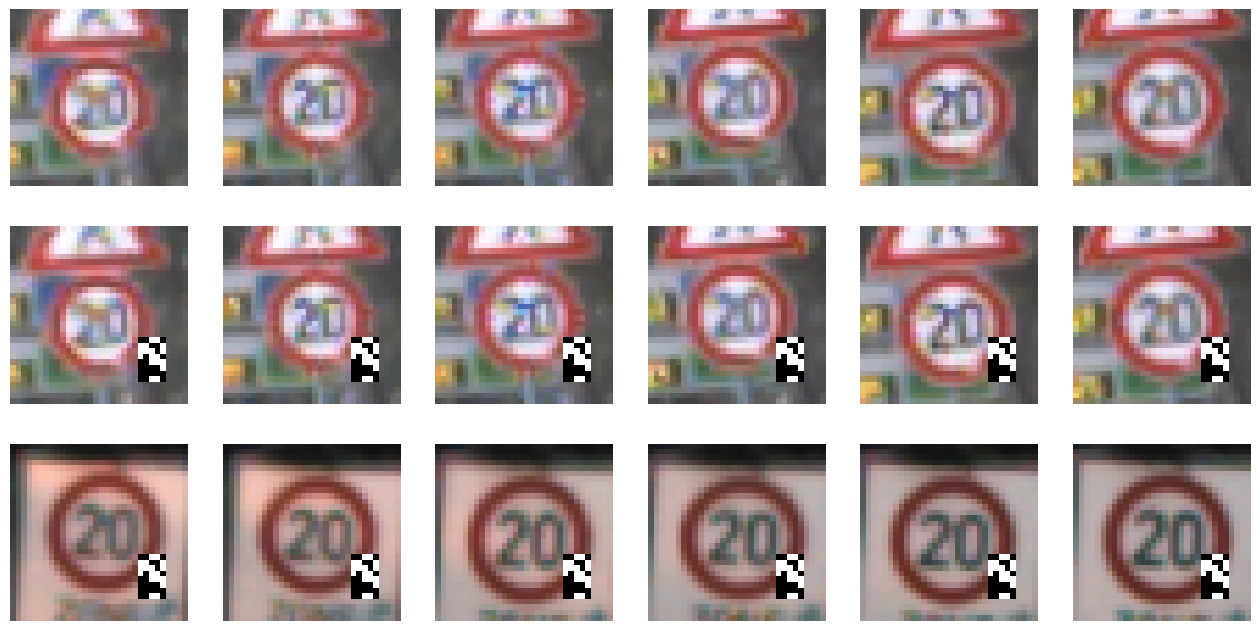

In [164]:
k = 2
info = infos[keys[k]]
model = models[keys[k]]
attack_specification = specifications[keys[k]]

print(json.dumps(info, indent=4))

img = clean_dataset[0][0]
# add trigger to image
img_with_trigger, _ = utils.insert_trigger(img, attack_specification)
print(model(img_with_trigger.unsqueeze(0)).argmax())
print(model(img.unsqueeze(0)).argmax())


fig, ax = plt.subplots(nrows=3, ncols=6, figsize=(16, 8))

for i in range(6):
    # First visualize an image without the trigger and with the trigger
    img = clean_dataset[i][0].unsqueeze(0)
    attack_specification = attack_specification
    img_with_trigger, _ = utils.insert_trigger(img, attack_specification)
    ax[0, i].imshow(img.squeeze(0).permute(1,2,0).numpy())
    ax[0, i].axis('off')
    ax[1, i].imshow(img_with_trigger.squeeze(0).permute(1,2,0).numpy())
    ax[1, i].axis('off')
    # Now visualize another image with the same trigger
    img = clean_dataset[100+i][0].unsqueeze(0)
    img_with_trigger, _ = utils.insert_trigger(img, attack_specification)
    ax[2, i].imshow(img_with_trigger.squeeze(0).permute(1,2,0).numpy())
    ax[2, i].axis('off')

plt.show()

## Побробуем собрать датасет при помощи кластеризации активаций

In [165]:
keys_by_trig_type = {
    "patch": diploma_utils.filter_by_trigger_type("patch", infos),
    "blended": diploma_utils.filter_by_trigger_type("blended", infos)
} 

In [166]:
batch_size = 300
num_epochs = 10  # for training
number_of_classes = 10

In [185]:
dim_reduction_method = 'FastICA'
nb_clusters = 20
nb_dims = 12
silhouette_threshold = 0.12


In [168]:
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import roc_auc_score, f1_score
import pickle

In [169]:
train_keys, test_keys = train_test_split(keys_by_trig_type["patch"])
train_keys_b, test_keys_b = train_test_split(keys_by_trig_type["blended"])
train_keys += train_keys_b
test_keys += test_keys_b

with open('gtsrb_train_keys20.pkl', 'wb') as f:
    pickle.dump(train_keys, f)
    
with open('gtsrb_test_keys20.pkl', 'wb') as f:
    pickle.dump(test_keys, f)


In [170]:
columns = ["key", "nb_classes", "nb_dims", "nb_clusters", "image_size"]
c2i = {col: i for i, col in enumerate(columns)}

In [172]:
def fill_dataframe(key, ac_result):
    df = np.empty((len(clean_dataset), len(columns)))
    df[:, c2i["key"]] = key
    df[:, c2i["nb_classes"]] = number_of_classes
    df[:, c2i["nb_dims"]] = nb_dims
    df[:, c2i["nb_clusters"]] = nb_clusters
    df[:, c2i["image_size"]] = np.prod(clean_dataset[0][0].shape)

    pdf = pd.DataFrame(df, columns=columns)
    return pdf.assign(**ac_result)

In [173]:
train_df = None
test_df = None

train_lables = []
test_lables = []

for t in ['train', 'test']:
    for key in tqdm(train_keys if t == 'train' else test_keys, leave=False):
        dataset, result = diploma_utils.get_ac_result(models[key], specifications[key], clean_dataset, nb_clusters=20)
        diploma_utils.remove_bad_features(result)
        pdf = fill_dataframe(key, result)

        cur_lables = np.zeros(len(dataset,))
        cur_lables[dataset.poisoned_indices] = 1
        
        if t == 'train':
            if train_df is not None:
                train_df = pd.concat([train_df, pdf], ignore_index=True, copy=False)
            else:
                train_df = pdf
                
            train_lables.append(cur_lables)
        else:
            if test_df is not None:
                test_df = pd.concat([test_df, pdf], ignore_index=True, copy=False)
            else:
                test_df = pdf
                
            test_lables.append(cur_lables)

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

In [303]:
train_df.tail()

,key,nb_classes,nb_dims,nb_clusters,image_size,classifier_ensurance,all_pred_label,all_clusters,all_sample_silhuette,all_sample_distance_to_cluster_centroid,all_sample_mean_distance_to_cluster_centroid_amoung_cluster,all_sample_relative_cluster_size,all_sample_activation_norm,all_sample_min_distance_to_other_classes,min_img_dist_to_cluster_means
5639995,0.0,10.0,12.0,6.0,784.0,1.000000,8,4,0.070786,6.906940e-310,6.906940e-310,6.907420,0.590398,2.376184,NaN
5639996,0.0,10.0,12.0,6.0,784.0,0.999999,3,4,0.071843,6.907102e-310,6.906940e-310,16.262607,0.040343,2.421578,NaN
5639997,0.0,10.0,12.0,6.0,784.0,0.999994,5,1,0.080462,6.906940e-310,6.906940e-310,20.878249,1.953352,2.148883,NaN
5639998,0.0,10.0,12.0,6.0,784.0,0.999893,6,1,0.074259,6.906940e-310,6.906940e-310,20.495873,0.277704,2.872769,NaN
5639999,0.0,10.0,12.0,6.0,784.0,0.999999,8,3,0.070786,6.906940e-310,6.906940e-310,21.293002,0.158444,3.053523,NaN


In [31]:
# сконкатинируем целевые лейблы в один numpy массив
train_lables_1d = np.concatenate(train_lables)
test_lables_1d = np.concatenate(test_lables)

In [186]:

def get_poisoned_dataset(clean_dataset, attack_specification, poisoned_indices=None):
    if attack_specification is None:
        return clean_dataset

    poisoned_dataset = utils.PoisonedDataset(clean_dataset, attack_specification)

    if poisoned_indices is not None:
        poisoned_dataset.poisoned_indices = poisoned_indices

    return poisoned_dataset

def get_min_img_dist_to_cluster_means_feature(
    keys,
    df,
    original_is_poisoned,
    clean_dataset,
    specifications,
    batch_size=1000,
    num_workers=0    
):
    # original_lables may be poisoned if dataset is
    all_feature = []
    is_from_the_same_class_feature = []
    image_shape = clean_dataset[0][0].shape
    for key in tqdm(keys):
        attack_specification = specifications[key]
        poisoned_dataset = get_poisoned_dataset(
            clean_dataset,
            attack_specification,
            poisoned_indices=original_is_poisoned[df.key == int(key)].nonzero()[0])

        class_cluster_to_id : dict[tuple[int, int], int] = {} 
        cluster_means_images = torch.zeros((num_classes * nb_clusters, *image_shape))
        

        # получаем кластера для каждого класса и усредняем их
        cur_key_dataset = df[df.key == int(key)]
        for target_class in range(num_classes):
            for cluster_i in range(nb_clusters):
                images_for_cluster_idx = (
                    (cur_key_dataset.all_pred_label == target_class) 
                    & (cur_key_dataset.all_clusters == cluster_i)).values.nonzero()[0]
                
                dev_dataloader = torch.utils.data.DataLoader(
                    Subset(poisoned_dataset, images_for_cluster_idx),
                    batch_size=batch_size, shuffle=False, num_workers=num_workers)

                mean_image = torch.zeros(image_shape)
                for images_set, _ in dev_dataloader:
                    mean_image += images_set.sum(dim=0)
                mean_image = mean_image / images_for_cluster_idx.shape[0]
                ind = target_class * nb_clusters + cluster_i
                class_cluster_to_id[(target_class, cluster_i)] = ind
                cluster_means_images[ind] = mean_image

        dev_dataloader = torch.utils.data.DataLoader(
            poisoned_dataset,
            batch_size=batch_size, shuffle=False, num_workers=num_workers)
        cur_key_dataset_val = cur_key_dataset.loc[:, ["all_pred_label", "all_clusters"]].values
        
        for i, (images_set, _) in enumerate(dev_dataloader):
            img_infos = cur_key_dataset_val[i * batch_size : i * batch_size + len(images_set)]
            min_dists = torch.cdist(images_set.flatten(1), cluster_means_images.flatten(1), p=1)
            # global md
            # global ind_md
            # md = min_dists
            # ind_md = np.column_stack(
                    # (np.arange(0, len(img_infos)), (img_infos[:, 0] * nb_clusters + img_infos[:, 1]))
                # )
            # return
            min_dists[
                np.arange(0, len(img_infos)), (img_infos[:, 0] * nb_clusters + img_infos[:, 1])
            ] = torch.inf
            min_dists = torch.nan_to_num(min_dists, nan=torch.inf)
            all_feature.append(min_dists.min(dim=1).values.numpy())
            # print(min_dists.argmin(dim=1))
            is_from_the_same_class_feature.append(np.equal((min_dists.argmin(dim=1) // nb_clusters).numpy(), img_infos[:, 0]))

    return np.concatenate(all_feature), np.concatenate(is_from_the_same_class_feature)
    # return np.concatenate(is_from_the_same_class_feature)



In [187]:
train_min_img_dist_to_cluster_means, f2train = get_min_img_dist_to_cluster_means_feature(
    train_keys, train_df, train_lables_1d, clean_dataset, specifications)
test_min_img_dist_to_cluster_means, f2test = get_min_img_dist_to_cluster_means_feature(
    test_keys, test_df, test_lables_1d, clean_dataset, specifications)

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

In [188]:
train_df = train_df.assign(min_img_dist_to_cluster_means=train_min_img_dist_to_cluster_means)
test_df = test_df.assign(min_img_dist_to_cluster_means=test_min_img_dist_to_cluster_means)
train_df = train_df.assign(min_img_dist_to_cluster_means_is_from_the_same_class=f2train)
test_df = test_df.assign(min_img_dist_to_cluster_means_is_from_the_same_class=f2test)

In [192]:
test_df_cleared = test_df.drop(["key", 'all_clusters', 'all_pred_label'], axis=1)
train_df_cleared = train_df.drop(["key", 'all_clusters', 'all_pred_label'], axis=1)

In [79]:
from sklearn.model_selection import GridSearchCV

#Instantiate CatBoostClassifier
cbc = CatBoostClassifier(verbose=30, auto_class_weights="Balanced")

#create the grid
grid = {'max_depth': [1,2,3,4,5], 'iterations': [2, 3, 5, 10, 20, 50]}

#Instantiate GridSearchCV
gscv = GridSearchCV(estimator = cbc, param_grid = grid, scoring ='accuracy', cv = 5)

#fit the model
gscv.fit(train_df_cleared, train_lables_1d)

#returns the estimator with the best performance
print(gscv.best_estimator_)

#returns the best score
print(gscv.best_score_)

#returns the best parameters
print(gscv.best_params_)

30:	learn: 0.3430523	total: 1.8s	remaining: 1.1s
49:	learn: 0.2916109	total: 2.98s	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.5962506	total: 60.2ms	remaining: 2.95s
30:	learn: 0.3643411	total: 2.12s	remaining: 1.3s
49:	learn: 0.3210559	total: 3.5s	remaining: 0us
0.7999584261681036
{'iterations': 50, 'max_depth': 5}


In [206]:
model = CatBoostClassifier(verbose=30, auto_class_weights="Balanced", iterations=20, max_depth=7)
# train the model
model.fit(train_df_cleared, train_lables_1d)


Learning rate set to 0.5
0:	learn: 0.4719363	total: 91.9ms	remaining: 1.75s
19:	learn: 0.2006440	total: 1.88s	remaining: 0us


In [207]:
preds_class = model.predict(test_df_cleared)
preds_proba = model.predict_proba(test_df_cleared)

print(f"{roc_auc_score(test_lables_1d, preds_proba[:, 1])=}")
print(f"{f1_score(test_lables_1d, preds_class)=}")

roc_auc_score(test_lables_1d, preds_proba[:, 1])=0.9349932591819651
f1_score(test_lables_1d, preds_class)=0.5644722935225729


In [105]:
# Посчитаем ROC-AUC оригинального AC
print(f"{roc_auc_score(test_lables_1d, 1/test_df_cleared.all_sample_silhuette.values)=}")

roc_auc_score(test_lables_1d, 1/test_df_cleared.all_sample_silhuette.values)=0.6813697002274098


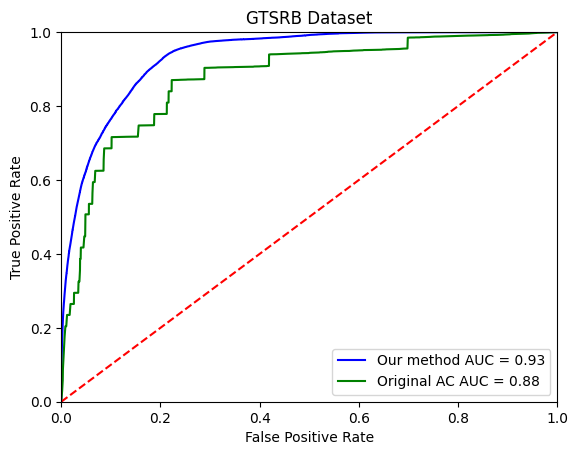

In [208]:
import sklearn.metrics as metrics

fpr, tpr, threshold = metrics.roc_curve(test_lables_1d, preds_proba[:, 1])
roc_auc = metrics.auc(fpr, tpr)

fpr_orig, tpr_orig, threshold_orig = metrics.roc_curve(test_lables_1d, 1/test_df_cleared.all_sample_silhuette.values)
roc_auc_orig = metrics.auc(fpr_orig, tpr_orig)

plt.title('GTSRB Dataset')
plt.plot(fpr, tpr, 'b', label = 'Our method AUC = %0.2f' % roc_auc)
plt.plot(fpr_orig, tpr_orig, 'g', label = 'Original AC AUC = %0.2f' % roc_auc_orig)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [156]:
model.get_feature_importance()

array([ 0.        ,  0.        ,  0.        ,  0.        , 32.64316   ,
       42.05642023,  0.        ,  0.        ,  0.        ,  0.        ,
       10.94916343, 13.14396564,  1.2072907 ])

In [157]:
train_df_cleared.columns[model.get_feature_importance() > 0]

Index(['classifier_ensurance', 'all_sample_silhuette',
       'all_sample_min_distance_to_other_classes',
       'min_img_dist_to_cluster_means',
       'min_img_dist_to_cluster_means_is_from_the_same_class'],
      dtype='object')

In [93]:
test_df = pd.read_csv("gtsrb_test.pd.csv", index_col=0)
test_lables_1d = np.load("gtsrb_test_lables_1d.np.npy")

In [134]:
test_df

,key,nb_classes,nb_dims,nb_clusters,image_size,classifier_ensurance,all_pred_label,all_clusters,all_sample_silhuette,all_sample_distance_to_cluster_centroid,all_sample_mean_distance_to_cluster_centroid_amoung_cluster,all_sample_relative_cluster_size,all_sample_activation_norm,all_sample_min_distance_to_other_classes,min_img_dist_to_cluster_means
0,292.0,10.0,12.0,6.0,3072.0,0.999924,0,4,0.157120,4.636521e-310,6.937588e-310,6.937588e-310,6.937588e-310,3.698879,395.29446
1,292.0,10.0,12.0,6.0,3072.0,0.999733,0,0,0.157120,6.937588e-310,4.636529e-310,4.636525e-310,4.636616e-310,3.527786,397.89612
2,292.0,10.0,12.0,6.0,3072.0,0.999876,11,1,0.106499,4.636521e-310,4.636430e-310,4.636430e-310,4.636430e-310,2.949281,445.95980
3,292.0,10.0,12.0,6.0,3072.0,0.999614,0,3,0.157120,4.636442e-310,4.636529e-310,4.636525e-310,4.636616e-310,3.142919,403.42730
4,292.0,10.0,12.0,6.0,3072.0,0.998144,0,1,0.157120,2.249735e+03,1.976263e-323,-1.800719e-14,3.787801e+00,3.241107,414.61606
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
852475,354.0,10.0,12.0,6.0,3072.0,0.999939,42,1,0.330995,-2.146011e+02,-3.732455e+03,2.252443e+05,-3.590781e+06,25.211380,98.27126
852476,354.0,10.0,12.0,6.0,3072.0,0.999682,42,1,0.330995,-3.314357e+05,-1.230322e-07,-2.607882e+01,-2.493653e+05,26.838816,109.26436
852477,354.0,10.0,12.0,6.0,3072.0,0.999919,42,1,0.330995,4.695405e+01,8.583201e-01,1.001396e+08,5.963431e-03,27.114811,116.46787
852478,354.0,10.0,12.0,6.0,3072.0,0.999889,42,1,0.330995,3.690716e+01,2.861570e-05,-1.947535e+05,1.374032e+03,26.604361,135.47917


In [158]:
model.calc_feature_statistics(train_df_cleared, target=train_lables_1d, plot_file="gtsrb_catboost_analysis.html", plot=False)
print()

In [ ]:
for t in np.arange(0.8, 1, 0.01):
    preds_prob = model.predict_proba(test_df_cleared)[:, 1]
    print(f"{t=} {f1_score(test_lables_1d, preds_prob>t)=}")

In [182]:
model.save_model("gtsrb_all.cb")

In [193]:
train_df.to_csv("gtsrb_train.pd.csv")
test_df.to_csv("gtsrb_test.pd.csv")

In [184]:
np.save("gtsrb_test_lables_1d.np", test_lables_1d)
np.save("gtsrb_train_lables_1d.np", train_lables_1d)

In [40]:
# попробуем восстановить триггеры

In [111]:
train_df = pd.read_csv("gtsrb_train.pd.csv", index_col=0)
test_df = pd.read_csv("gtsrb_test.pd.csv", index_col=0)
test_lables_1d = np.load("gtsrb_test_lables_1d.np.npy")
train_lables_1d = np.load("gtsrb_train_lables_1d.np.npy")
model = CatBoostClassifier()
model.load_model("gtsrb_all.cb")

with open('gtsrb_train_keys.pkl', "rb") as f:
    train_keys = pickle.load(f)
    
with open('gtsrb_test_keys.pkl', "rb") as f:
    test_keys = pickle.load(f)
    

In [112]:
test_df.head()

,key,nb_classes,nb_dims,nb_clusters,image_size,classifier_ensurance,all_pred_label,all_clusters,all_sample_silhuette,all_sample_distance_to_cluster_centroid,all_sample_mean_distance_to_cluster_centroid_amoung_cluster,all_sample_relative_cluster_size,all_sample_activation_norm,all_sample_min_distance_to_other_classes,min_img_dist_to_cluster_means
0,292.0,10.0,12.0,6.0,3072.0,0.999924,0,4,0.157120,4.636521e-310,6.937588e-310,6.937588e-310,6.937588e-310,3.698879,395.29446
1,292.0,10.0,12.0,6.0,3072.0,0.999733,0,0,0.157120,6.937588e-310,4.636529e-310,4.636525e-310,4.636616e-310,3.527786,397.89612
2,292.0,10.0,12.0,6.0,3072.0,0.999876,11,1,0.106499,4.636521e-310,4.636430e-310,4.636430e-310,4.636430e-310,2.949281,445.95980
3,292.0,10.0,12.0,6.0,3072.0,0.999614,0,3,0.157120,4.636442e-310,4.636529e-310,4.636525e-310,4.636616e-310,3.142919,403.42730
4,292.0,10.0,12.0,6.0,3072.0,0.998144,0,1,0.157120,2.249735e+03,1.976263e-323,-1.800719e-14,3.787801e+00,3.241107,414.61606


In [209]:
def get_filtered_data(dataloader, mask=None, predicted_lables=None, filter_lable=None):
    """Return samples that is True in mask"""
    j = 0
    for imgs, lable in dataloader:
        for i in range(imgs.shape[0]):
            if (
                (mask is None or mask[j]) 
                and (filter_lable is None or (
                    (
                        predicted_lables is None and
                        filter_lable == lable[i].item()
                    ) or (
                        predicted_lables is not None and
                        filter_lable == predicted_lables[j]
                    )
                ))
            ):
                yield imgs[i]
            j += 1

In [210]:
from scipy.spatial.distance import cdist

In [211]:
class PoisonedDataset(torch.utils.data.Dataset):
    def __init__(self, clean_data, target_lable, triggers, masks, cluster_means):
        super().__init__()
        self.clean_data = clean_data
        self.target_lable = target_lable
        self.triggers = triggers
        self.masks = masks
        self.cluster_means = cluster_means
        self.means_without_trigger = self.cluster_means - self.triggers

    def __getitem__(self, idx):
        img, lable = self.clean_data[idx]
        
        if lable == self.target_lable:
            return img, lable
        else:
            ## Применяем триггер из наиболее близкого по усредненному изображению к текущему изображению
            ### Определяем наиболее близкое усреднённое изображение
            axis = tuple(range(1, len(self.cluster_means.shape)+1))
            trigger_id = torch.argmin(torch.norm(
                self.means_without_trigger - img.unsqueeze(0), dim=tuple(range(1, len(self.cluster_means.shape))), p=1)) # L1 metric
            trig_plus_image = img.cpu() * (1-self.masks[trigger_id].cpu()) + self.triggers[trigger_id].cpu() * self.masks[trigger_id].cpu()
            return trig_plus_image, self.target_lable

    def __len__(self):
        return len(self.clean_data)

In [212]:
from tqdm.notebook import tqdm

In [213]:
len(specifications)

125

In [214]:
img.shape

torch.Size([1, 3, 32, 32])

In [215]:
import trojanzoo_.torch_adopted.defenses.backdoor.model_inspection.neural_cleanse
importlib.reload(trojanzoo_.torch_adopted.defenses.backdoor.model_inspection.neural_cleanse)

NeuralCleanse = trojanzoo_.torch_adopted.defenses.backdoor.model_inspection.neural_cleanse.NeuralCleanse

def get_mask(nn_model, dev_dataloader, pattern, target_class):
    nn_cleanse = NeuralCleanse(
        nn_model,
        list(range(10)),
        dev_dataloader,
        img_shape=[3, 32, 32],
        initial_pattern=pattern,
        defense_remask_epoch=3
    )
    nn_cleanse.optimize_mark(target_class, verbose=False)
    return nn_cleanse.mask

In [216]:
predicted_test_lables = model.predict(test_df)
results = []
for key in tqdm(test_keys):
    # 1. по тесту выделяем триггеры
    # получаем отправленные изображения
    ## установи в PoisonedDataset poisoned_indices в соответствии с test_lables_1d
    attack_specification = specifications[key]
    poisoned_dataset = utils.PoisonedDataset(clean_dataset, attack_specification) 
    poisoned_dataset.poisoned_indices = test_lables_1d[test_df.key == int(key)].nonzero()[0]
    dev_dataloader = torch.utils.data.DataLoader(poisoned_dataset, batch_size=batch_size, shuffle=False, num_workers=8)
    nn_model = models[key]
    nn_model = nn_model.eval()
    nn_model = nn_model.cuda()
    
    # получаем кластера для предсказанных отравленных изображений
    is_poisoned_pred = predicted_test_lables[test_df.key == int(key)].astype(bool)
    cur_key_dataset = test_df[test_df.key == int(key)]
    cur_key_dataset_pred_poisoned_part = cur_key_dataset[is_poisoned_pred]
    
    pred_poisoned_target_classes = cur_key_dataset_pred_poisoned_part.all_pred_label.unique()
    for target_class in pred_poisoned_target_classes:
        triggers = [] # cluster -> trigger
        masks = []
        cluster_means = [] # cluster -> mean image
        cur_key_class_dataset_pred_poisoned_part = cur_key_dataset_pred_poisoned_part[
            cur_key_dataset_pred_poisoned_part.all_pred_label == target_class]
        
        if cur_key_class_dataset_pred_poisoned_part.shape[0] < cur_key_dataset.shape[0] / 200:
            continue  # мы не хотим анализировать слишком маленькие кластера, поскольку это займёт много времени
        
        ### усредняем изображения для кластеров класса
        assert(cur_key_dataset.shape[0] == len(is_poisoned_pred))
        poisoned_images_pred = torch.stack(list(
            get_filtered_data(dev_dataloader, is_poisoned_pred, cur_key_dataset.all_pred_label.values, target_class)
        ))
        ### ещё раз применить фильтрацию для получения изображений конкретного кластера
        for cluster in cur_key_class_dataset_pred_poisoned_part.all_clusters.unique():
            poisonde_images_for_cluster = poisoned_images_pred[
               (cur_key_class_dataset_pred_poisoned_part.all_clusters == cluster).values
            ]
            samples_cnt = poisonde_images_for_cluster.shape[0]
            mean_image = poisonde_images_for_cluster.sum(axis=0) / samples_cnt
            trigger_filtered = torch.where(
                (mean_image >= (mean_image.max()-0.1)) 
                | (mean_image <= 0.1), mean_image, torch.zeros_like(mean_image)
            )
            triggers.append(trigger_filtered)
            masks.append(get_mask(nn_model, dev_dataloader, trigger_filtered, target_class))
            cluster_means.append(mean_image)
            
        triggers = torch.stack(triggers)
        masks = torch.stack(masks)
        cluster_means = torch.stack(cluster_means)

        # 2. применяем триггеры к чистому датасету
        my_poisoned_dataset = PoisonedDataset(clean_dataset, target_class, triggers, masks, cluster_means)
        my_poisoned_loader = torch.utils.data.DataLoader(my_poisoned_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)
        
    
        # 3. смотрим качество отравления
        _, attack_success_rate = utils.evaluate(my_poisoned_loader, nn_model)

        print(f"{attack_success_rate=}\n{target_class=}\n{key=}\n")
        results.append((attack_success_rate, target_class, key, masks, triggers, cluster_means))
    


  0%|          | 0/32 [00:00<?, ?it/s]

attack_success_rate=1.0
target_class=11
key='0292'

attack_success_rate=1.0
target_class=2
key='0292'

attack_success_rate=1.0
target_class=38
key='0301'

attack_success_rate=1.0
target_class=1
key='0301'

attack_success_rate=1.0
target_class=2
key='0301'

attack_success_rate=1.0
target_class=16
key='0288'

attack_success_rate=1.0
target_class=38
key='0288'

attack_success_rate=0.9999249249249249
target_class=1
key='0308'

attack_success_rate=0.9999624624624625
target_class=2
key='0308'

attack_success_rate=1.0
target_class=30
key='0312'

attack_success_rate=0.9999249249249249
target_class=2
key='0312'

attack_success_rate=1.0
target_class=12
key='0276'

attack_success_rate=0.9999249249249249
target_class=1
key='0276'

attack_success_rate=1.0
target_class=2
key='0276'

attack_success_rate=0.9993618618618618
target_class=4
key='0276'

attack_success_rate=1.0
target_class=10
key='0276'

attack_success_rate=1.0
target_class=13
key='0276'

attack_success_rate=1.0
target_class=25
key='0303'

In [219]:
with open("gtsrb_triggers_and_masks.pkl", "wb") as f:
    pickle.dump(results, f)

In [ ]:
prev_results = results

In [130]:
attack_success_rate, target_class, key, masks, triggers, cluster_means = results[0]

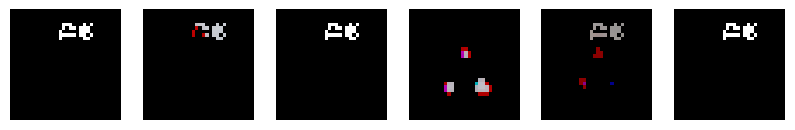

In [132]:
fig, ax = plt.subplots(nrows=1, ncols=len(cluster_means), figsize=(10, 10))

for i in range(len(cluster_means)):
    ax[i].imshow(triggers[i].permute(1,2,0).numpy())
    ax[i].axis('off')

plt.show()

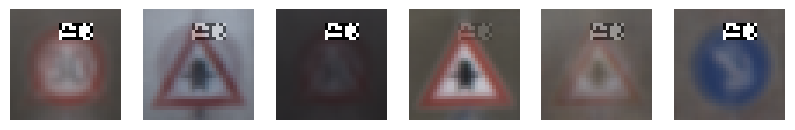

In [133]:
fig, ax = plt.subplots(nrows=1, ncols=len(cluster_means), figsize=(10, 10))

for i in range(len(cluster_means)):
    ax[i].imshow(cluster_means[i].permute(1,2,0).numpy())
    ax[i].axis('off')

plt.show()